<a href="https://colab.research.google.com/github/wujciak/thesis_colab/blob/main/cnn_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieć splotowa
Pozbyłem się problemu z NaN, teraz należy poprawić skuteczność i zmniejszyć starty w szkoleniu modelu.


# Instalacja bibliotek

In [1]:
!pip install tensorflow
!pip install keras

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

# Normalizacja danych

In [3]:
# Ścieżka do zbioru danych
dataset_dir = "/content/drive/MyDrive/Colab Notebooks/alg_and_batch1"

# Parametry stałe
img_height = 256
img_width = 256
batch_size = 32

# Normalizacja i podział datasetu (20% na walidację)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['benign', 'malignant'],
    color_mode='grayscale',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes=['benign', 'malignant'],
    color_mode='grayscale',
    subset='validation'
)

# Wyliczenie wag klas
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Found 4996 images belonging to 2 classes.
Found 1248 images belonging to 2 classes.
Class weights: {0: 1.086086956521739, 1: 0.9265578635014837}


In [4]:
# Wyświetlenie klas i ich oznaczeń w modelu
class_names = train_generator.class_indices
print(class_names)

{'benign': 0, 'malignant': 1}


In [5]:
# Sprawdzenie czy dane nie zawierają NaN
for images, labels in train_generator:
    assert not np.any(np.isnan(images)), "NaN values found in input data"
    break

for images, labels in val_generator:
    assert not np.any(np.isnan(images)), "NaN values found in input data"
    break

# Prezentacja danych

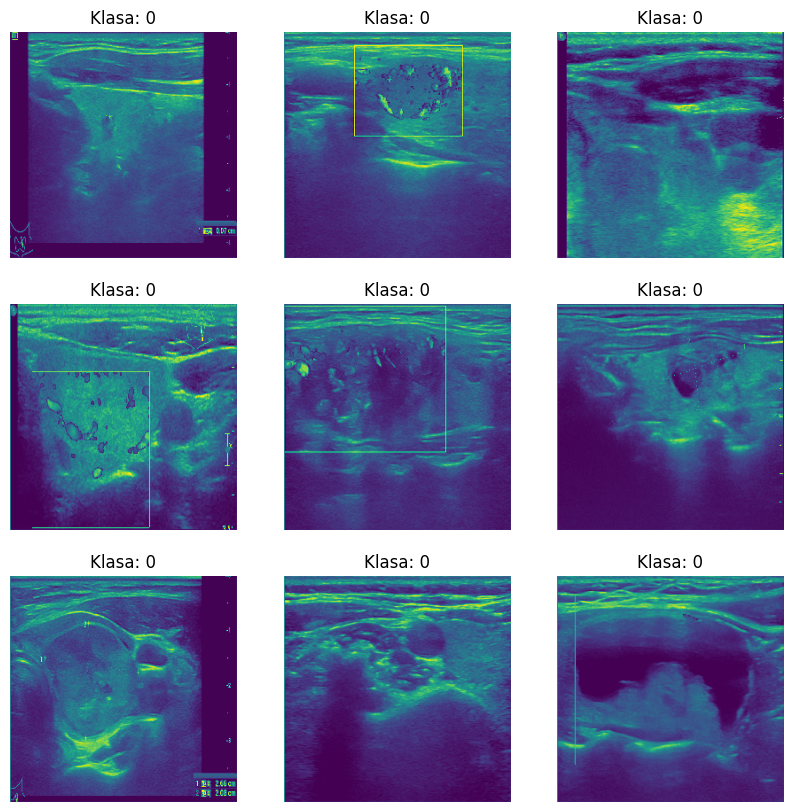

In [7]:
# Pobranie przykładowych batchy danych
images, labels = next(train_generator)

# Wyświetlenie kilku przykładowych zdjęć
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Klasa: {labels[i].argmax()}")  # 0: benign, 1: malignant
    plt.axis("off")

plt.show()

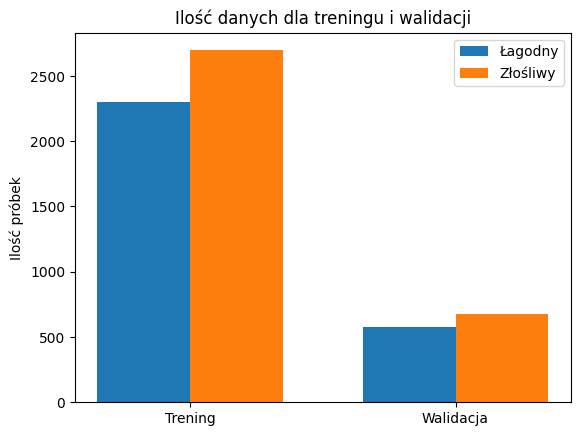

Train class counts: 4996
Validation class counts: 1248


In [8]:
# Zliczenie ilości danych w każdym zbiorze
train_benign = np.sum(train_generator.classes == 0)
train_malignant = np.sum(train_generator.classes == 1)
val_benign = np.sum(val_generator.classes == 0)
val_malignant = np.sum(val_generator.classes == 1)

# Dane do wykresu
categories = ['Trening', 'Walidacja']
benign_counts = [train_benign, val_benign]
malignant_counts = [train_malignant, val_malignant]

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(len(categories)) - width/2, benign_counts, width, label='Łagodny')
rects2 = ax.bar(np.arange(len(categories)) + width/2, malignant_counts, width, label='Złośliwy')

ax.set_ylabel('Ilość próbek')
ax.set_title('Ilość danych dla treningu i walidacji')
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.legend()

plt.show()

print("Train class counts:", train_generator.samples)
print("Validation class counts:", val_generator.samples)

# Budowa modelu i trening

In [13]:
# Architektura modelu CNN
model = models.Sequential()
model.add(Input(shape=(img_height, img_width, 1)))

model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25)) # powinna być mała wartość
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,167,489 (65.49 MB)

 Trainable params: 17,166,529 (65.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-6), # weight decay = bardzo mały, np. 1e-5, 3e-6
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4857 - loss: 2.1403
Epoch 1: val_loss improved from inf to 9.87300, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 1352s 8s/step - accuracy: 0.4857 - loss: 2.1334 - val_accuracy: 0.4599 - val_loss: 9.8730 - learning_rate: 1.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5630 - loss: 0.6814
Epoch 2: val_loss improved from 9.87300 to 2.68251, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 213ms/step - accuracy: 0.5631 - loss: 0.6814 - val_accuracy: 0.4599 - val_loss: 2.6825 - learning_rate: 1.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6000 - loss: 0.6622
Epoch 3: val_loss improved from 2.68251 to 0.79021, saving model to best_model.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.6000 - loss: 0.6622 - val_accuracy: 0.4848 - val_loss: 0.7902 - learning_rate: 1.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - 

# Wyniki uczenia

In [22]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy} \nValidation loss: {val_loss}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.5648 - loss: 0.6836
Validation Accuracy: 0.5729166865348816 
Validation loss: 0.6792051196098328


In [21]:
from sklearn.metrics import classification_report

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['benign', 'malignant']))


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step
              precision    recall  f1-score   support

      benign       0.46      1.00      0.63       574
   malignant       0.00      0.00      0.00       674

    accuracy                           0.46      1248
   macro avg       0.23      0.50      0.32      1248
weighted avg       0.21      0.46      0.29      1248



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Wykres wyników

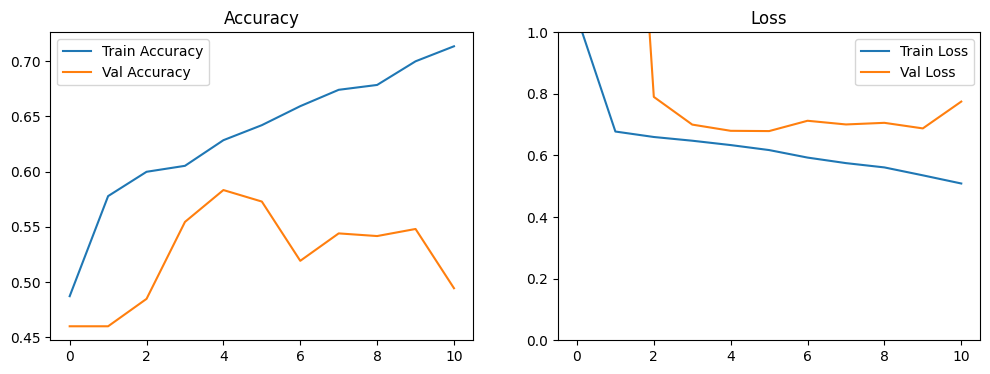

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.ylim(0, 1)
plt.title('Loss')
plt.show()

# Przykładowe 9 predykcji z modelu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


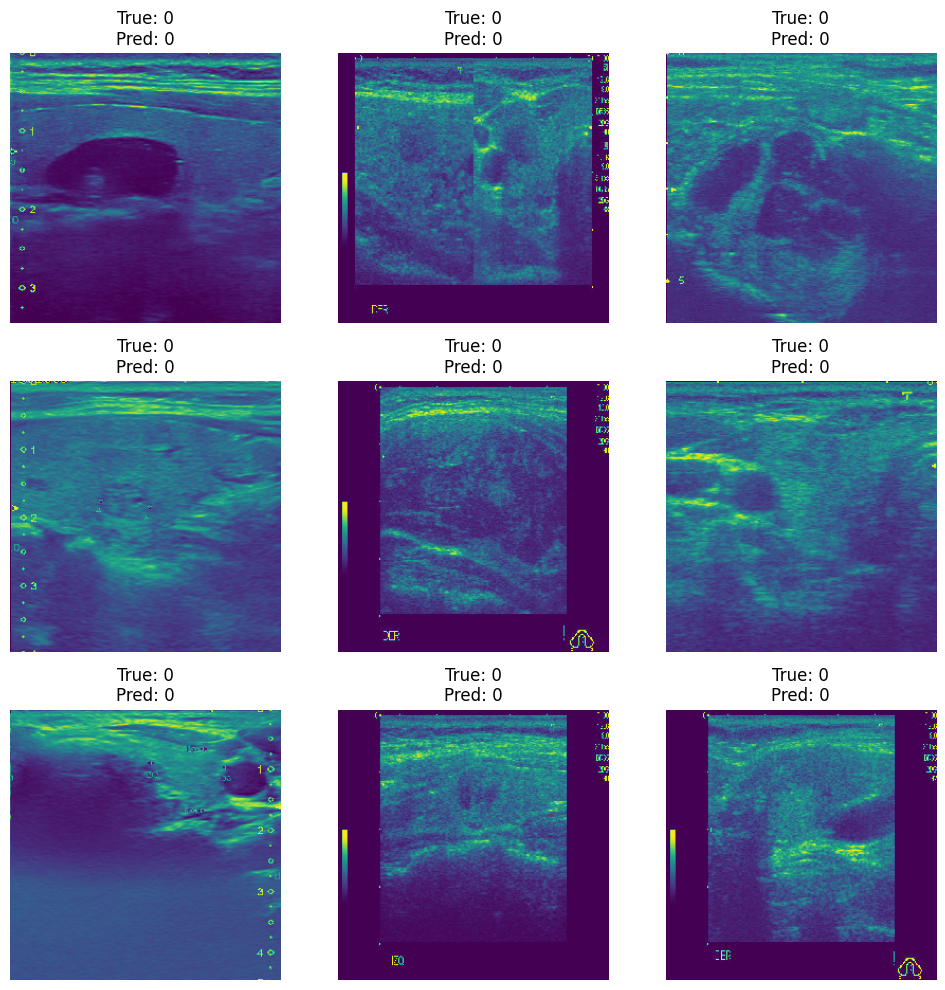

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Pobranie obrazów i etykiet
img, label = next(val_generator)

# Liczba obrazów w siatce (3x3)
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Stworzenie siatki wykresów
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(img):
        image = img[i]
        true_label = np.argmax(label[i])
        pred_label = np.argmax(model.predict(image[np.newaxis, ...]))

        ax.imshow(image)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

# Dopasowanie układu i wyświetlenie
plt.tight_layout()
plt.show()